# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from scipy import ndimage
import random
from IPython.display import clear_output

# ACO modeling

In [2]:
class AntColonyOptimization:
  # Initialize ACO parameters
  def __init__(self, image, ants=100, iterations=50, alpha=1.0, beta=2.0, p=0.5,
                  q=100.0, tau_0=0.1, update_strat='as'):
    # Defined parameters
    self.image = image               # array
    self.height, self.width = image.shape
    self.ants = ants                 # int: num ants in colony
    self.iterations = iterations     # int: num iterations for algo
    self.alpha = alpha               # float: pheromone importance factor
    self.beta = beta                 # float: heuristic importance factor
    self.p = p                       # float: pheromone evaporation rate
    self.q = q                       # float: pheromone deposit factor
    self.tau_0 = tau_0               # float: initial pheromone value
    self.update_strat = update_strat # str: {"ib", "as", "bs"}
    # http://www.scholarpedia.org/article/Ant_colony_optimization#ConstructAntSolutions
    # I actually don't know what "as-update" does

    # Initialize pheromone matrix
    self.tau = np.ones((self.height, self.width)) * tau_0

    # Simplified image into edges (replacable methods?)
    self.edge_info = filters.sobel(image)
    self.edge_info = self.edge_info / np.max(self.edge_info)

    # Heuristic information based on edge information
    self.n = 1.0 / (self.edge_info + 0.1)

    # Best solutions tracking
    self.best_segmentation = None  # Best-so-far solution (s^bs)
    self.best_fitness = float('-inf')
    self.iteration_best_segmentation = None  # Iteration-best solution (s^ib)
    self.iteration_best_fitness = float('-inf')

  def run(self, visualize_progress=True):
        for iteration in range(self.iterations):
            # Initialize ant variables
            ant_positions = [(random.randint(0, self.height-1), random.randint(0, self.width-1))
                            for _ in range(self.ants)]
            ant_paths = [[] for _ in range(self.ants)]
            max_steps = (self.height * self.width) // 20

            # Update ant positions based on ACO probability
            for ant_i in range(self.ants):
                current_pos = ant_positions[ant_i]
                ant_paths[ant_i].append(current_pos)

                for _ in range(max_steps):
                    next_positions = self._get_neighbors(current_pos)

                    if not next_positions:
                        break

                    next_pos = self._choose_next_position(current_pos, next_positions)
                    current_pos = next_pos
                    ant_paths[ant_i].append(current_pos)

            # Create segmentations from ant paths
            segmentations = self._create_segmentations(ant_paths)

            # Check fitness value for convergence
            fitness_values = [self._evaluate_fitness(seg) for seg in segmentations]

            # Update best segmentation
            i_best = np.argmax(fitness_values)
            if fitness_values[i_best] > self.best_fitness:
                self.best_segmentation = segmentations[i_best]
                self.best_fitness = fitness_values[i_best]

            # Update pheromone
            self._update_pheromone(ant_paths, fitness_values)

            # Visualize progress
            if visualize_progress and (iteration % 5 == 0 or iteration == self.iterations - 1):
                clear_output(wait=True)
                self._visualize_progress(iteration)

        return self.best_segmentation

  def _get_neighbors(self, pos):
        i, j = pos
        neighbors = []

        # 8-neighborhood: https://www.imageprocessingplace.com/downloads_V3/root_downloads/tutorials/contour_tracing_Abeer_George_Ghuneim/connect.html
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue

                ni, nj = i + di, j + dj

                if 0 <= ni < self.height and 0 <= nj < self.width:
                    neighbors.append((ni, nj))

        return neighbors

  def _choose_next_position(self, current_pos, next_positions):
      probabilities = []

      for pos in next_positions:
          i, j = pos
          # Calculate ACO probability
          pheromone_val = self.tau[i, j] ** self.alpha
          heuristic_val = self.n[i, j] ** self.beta
          probability = pheromone_val * heuristic_val
          probabilities.append(probability)

      # Normalize probabilities
      total = sum(probabilities)
      if total == 0:
          return random.choice(next_positions)

      probabilities = [p / total for p in probabilities]

      # Choose next position based randomized probabilities
      r = random.random()
      cumsum = 0
      for i, probability in enumerate(probabilities):
          cumsum += probability
          if r <= cumsum:
              return next_positions[i]

      return next_positions[-1]

  def _create_segmentations(self, ant_paths):
      segmentations = []

      for path in ant_paths:
          segmentation = np.zeros((self.height, self.width), dtype=bool)

          for i, j in path:
              segmentation[i, j] = True

          # Use morphological operations to fill gaps and remove small objects
          segmentation = ndimage.binary_dilation(segmentation, iterations=2)
          segmentation = ndimage.binary_erosion(segmentation, iterations=1)
          segmentation = ndimage.binary_fill_holes(segmentation)

          segmentations.append(segmentation)

      return segmentations

  def _evaluate_fitness(self, segmentation): # not sure if we're keeping this method - read more papers
      # Calculate the average edge information for the segmentation boundary
      boundary = segmentation ^ ndimage.binary_erosion(segmentation)
      if np.sum(boundary) == 0:
          return float('-inf')

      edge_strength = np.mean(self.edge_info[boundary])

      # Calculate region homogeneity
      foreground = self.image[segmentation]
      background = self.image[~segmentation]

      if len(foreground) == 0 or len(background) == 0:
          return float('-inf')

      fg_std = np.std(foreground) if len(foreground) > 1 else 0
      bg_std = np.std(background) if len(background) > 1 else 0

      homogeneity = 1.0 / (fg_std + bg_std + 0.1)
      fitness = edge_strength + 0.5 * homogeneity

      return fitness

  def _update_pheromone(self, ant_paths, fitness_values):
      # ACO evaporation rule
      self.tau *= (1 - self.p)

      # Deposit new pheromone based on fitness
      for path, fitness in zip(ant_paths, fitness_values):
          if fitness <= 0:
              continue

          q = self.q * fitness

          for i, j in path:
              self.tau[i, j] += q

  def _visualize_progress(self, iteration):
      plt.figure(figsize=(12, 4))

      # Original image
      plt.subplot(1, 3, 1)
      plt.imshow(self.image, cmap='gray')
      plt.title("Original Image")
      plt.axis('off')

      # Pheromone matrix
      plt.subplot(1, 3, 2)
      plt.imshow(self.tau, cmap='hot')
      plt.title(f"Pheromone Matrix (Iteration {iteration+1})")
      plt.axis('off')

      # Best segmentation so far
      plt.subplot(1, 3, 3)
      if self.best_segmentation is not None:
          plt.imshow(self.best_segmentation, cmap='gray')
          plt.title(f"Best Segmentation (Fitness: {self.best_fitness:.4f})")
      else:
          plt.title("No valid segmentation yet")
      plt.axis('off')

      plt.tight_layout()

# IMAGE PROCESSING

In [3]:
def load_and_preprocess_image(image_path, resize=None):
    """Load and preprocess image for segmentation"""
    # Load image
    img = io.imread(image_path)

    # Resize if needed
    if resize is not None:
        from skimage.transform import resize as sk_resize
        img = sk_resize(img, resize)

    # Convert to grayscale
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = color.rgb2gray(img)

    return img

# IMAGE SEGMENTATION

In [4]:
def run_aco_segmentation(image_path, resize=None, ants=20, iterations=30,
                        alpha=1.0, beta=2.0, p=0.3, q=100.0):
    # Load and preprocess image
    img = load_and_preprocess_image(image_path, resize)

    # Run ACO segmentation
    aco = AntColonyOptimization(
        image=img,
        ants=ants,
        iterations=iterations,
        alpha=alpha,
        beta=beta,
        p=p,
        q=q
    )

    segmentation = aco.run()

    # Visualize final results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(segmentation, cmap='gray')
    plt.title("ACO Segmentation")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # Create colored overlay
    overlay = np.zeros((*img.shape, 3))
    overlay[..., 0] = img  # Red channel
    overlay[..., 1] = img  # Green channel
    overlay[..., 2] = img  # Blue channel

    # Highlight segmentation in red
    overlay[segmentation, 0] = 1.0
    overlay[segmentation, 1] = 0.0
    overlay[segmentation, 2] = 0.0

    plt.imshow(overlay)
    plt.title("Segmentation Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return segmentation

# IMPLEMENTATION

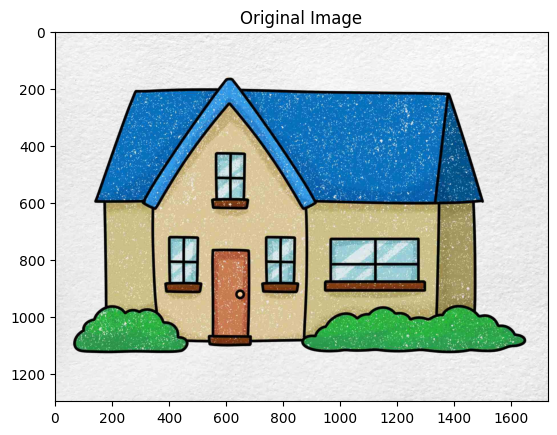

In [5]:
from skimage import io
import matplotlib.pyplot as plt

url = 'https://helloartsy.com/wp-content/uploads/kids/places/how-to-draw-a-house/how-to-draw-a-house-step-6.jpg'
image = io.imread(url)

plt.imshow(image)
plt.title('Original Image')
plt.show()

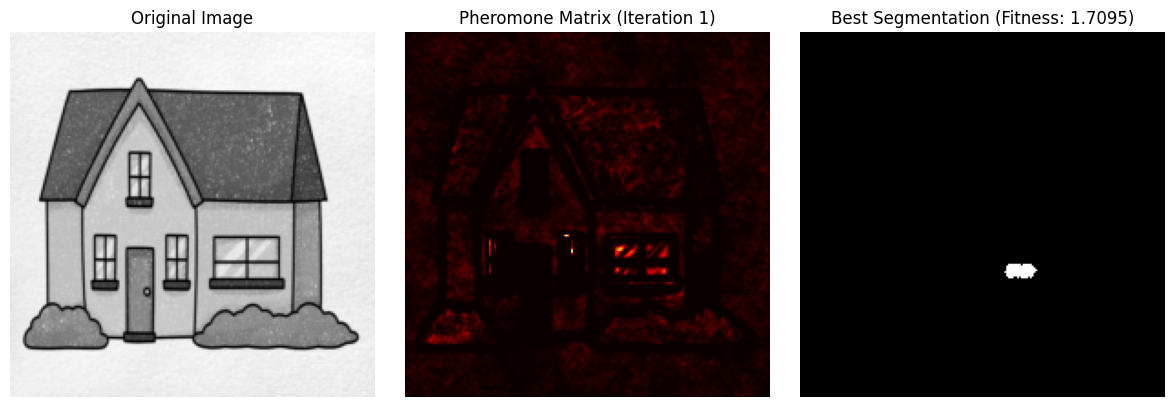

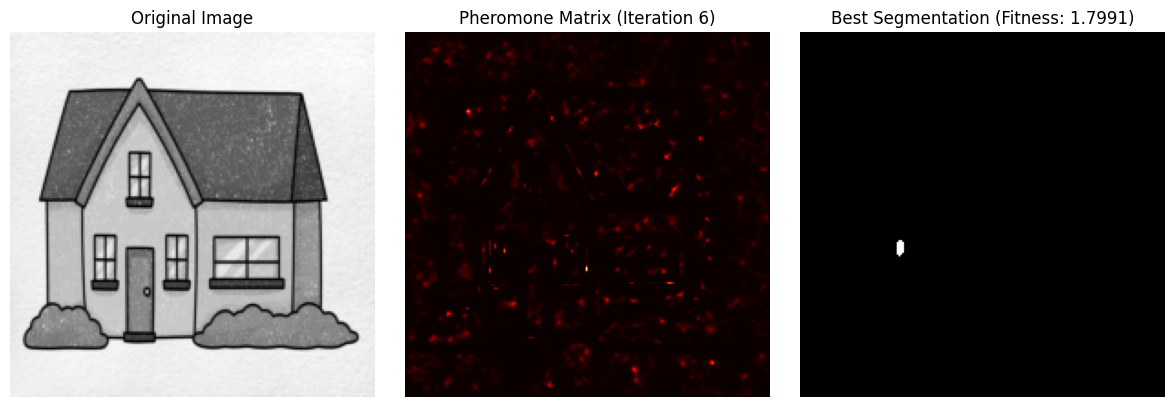

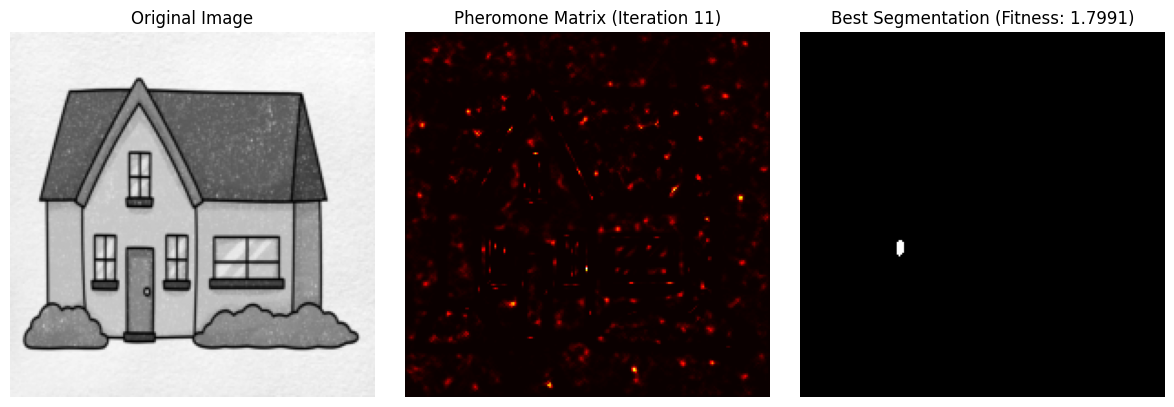

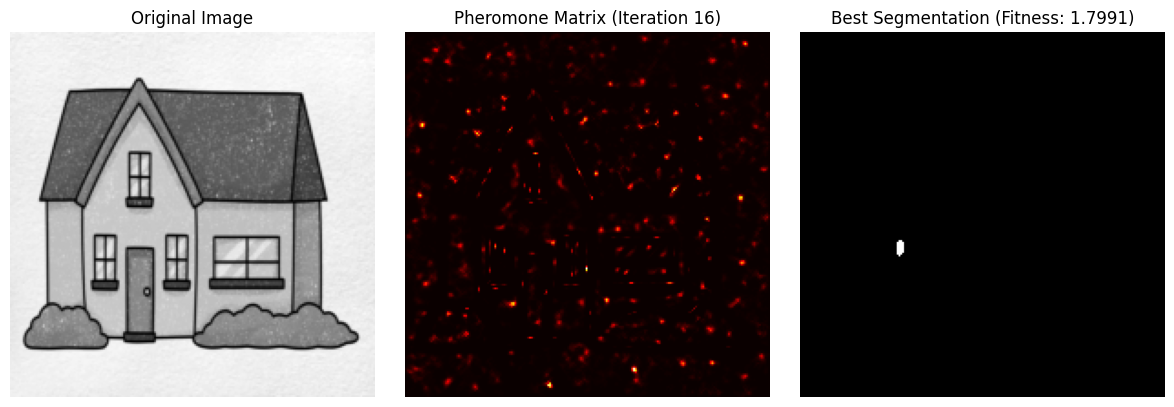

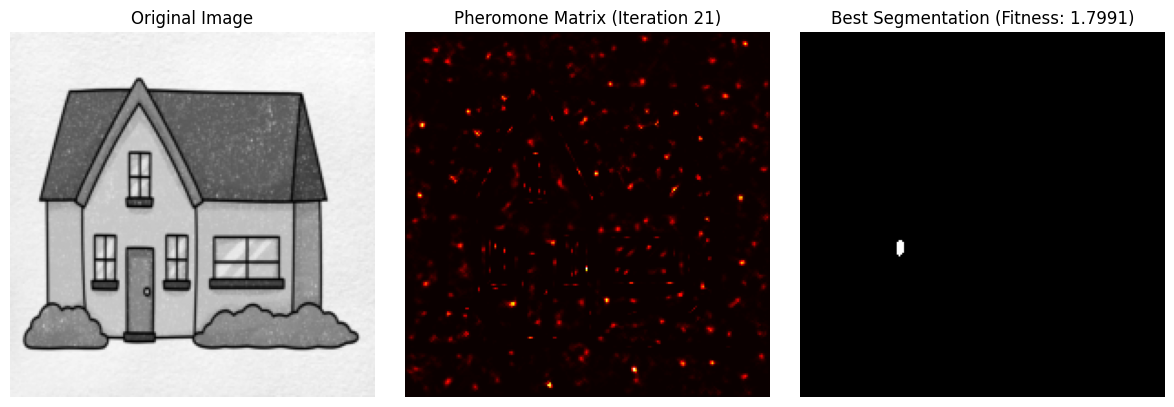

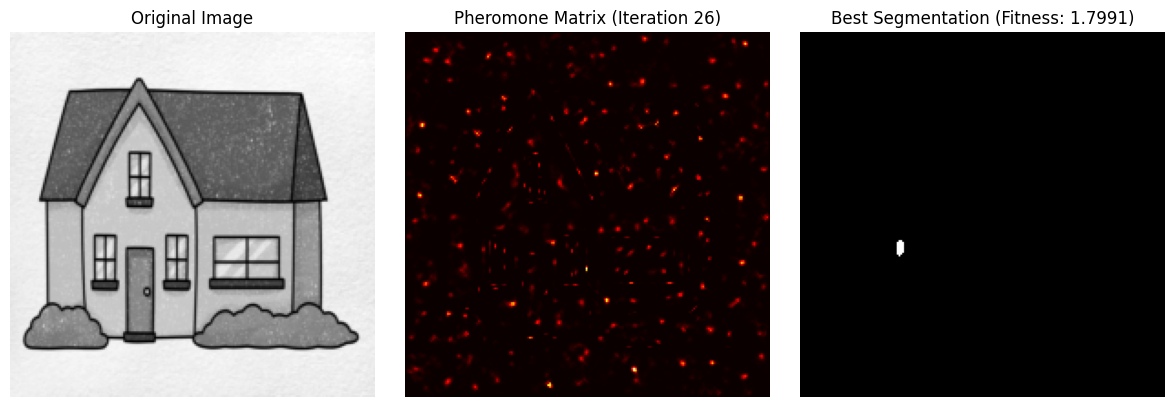

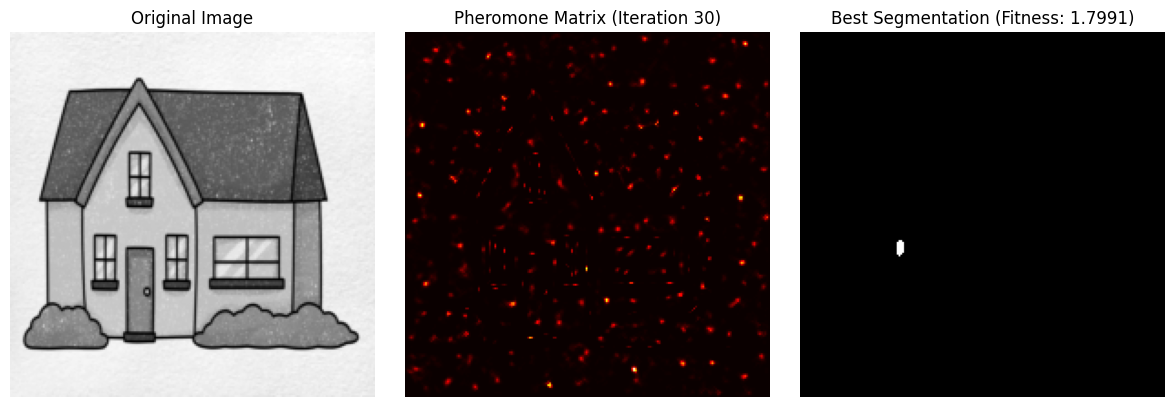

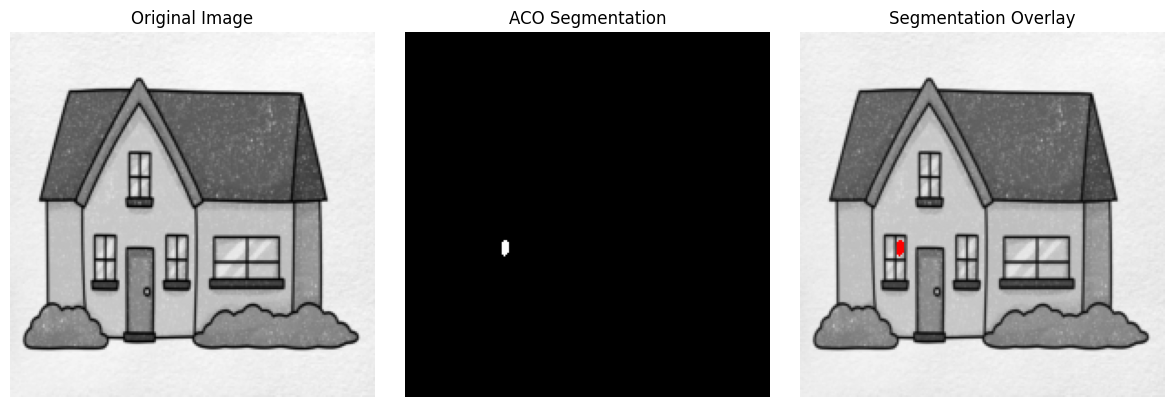

In [7]:
segmentation = run_aco_segmentation(
    url,
    resize=(200, 200),
    ants=200,
    iterations=30,
    alpha=0.8,
    beta=3.0,
    p=0.005,
    q=200.0
)